# Quality assessment: Ice sheet surface elevation change rate for Greenland and Antarctica from 1992 to present derived from satellite observations

### Use Case: Monitoring the spatial distribution of Greenland and Antarctic ice sheet thinning rates over the last several decades to be used in the context of Earth System modeling

### User Question: How accurate and spatially/temporally complete are the ice sheet surface elevation change data and how does it affect estimates of ice sheet-related volume changes, its (intra/interannual) variability and its temporal trends?

This script summarizes the scientific quality assessment provided for the C3S_520 service regarding Surface Elevation Change (SEC) data for the Greenland (GrIS) and Antarctic Ice Sheet (AIS) as they are available on the Climate Data Store (CDS) [version 3.0].

## General description

The surface elevation change product quantifies the change of the surface elevation of the ice sheets and in that sense provides volume changes of the ice sheets. Mapping ice sheet surface elevation change and its temporal evolution provides key information for investigating the response of ice sheets to climate change. Remote sensing techniques that use satellite data are the only feasible manner to derive accurate surface elevation changes of the remote ice sheets on a regular basis and on a large spatial scale. Remote sensing devices are able to inspect directly and repeatedly large areas of ice, and, as such are able to examine the surface of the ice sheets. SEC data on the CDS are derived from satellite radar altimetry, followed by filtering, corrections, and (pre/post-)processing. Repeated measurements and the necessary processing of the acquired raw altimetric data transforms this information into surface elevation changes. These techniques, however, also have their limitations of which the user should take note when using the product.

Radar altimeters, in contrast to laser altimeters, provide, for example, measurements in all weather conditions, but in contrast have a much larger footprint which results in a less finer precision of the measurements. This especially provides difficulties around the margins, where complex and high-slope terrain prevails. The radar signal can furthermore penetrate into the snowpack until a certain depth, depending on the properties of the snow layers and the frequency of the sensor. Snow melting allows, for example, for variable snowpack penetration depths of the radar pulse (e.g. due to a changing liquid water content or refrozen ice lenses), hence possibly introducing artificial elevation changes (i.e. for example when the radar pulse is reflected from liquid water within the snowpack). Moreover, surface elevation changes can be thought of as volume changes and hence do not necessarily equal mass changes, because the signal may also comprise effects from changes in the firn layer thickness (densification of firn results in a decrease in surface elevation with no related mass change) and rebound from glacial isostatic adjustment as a response to past and present ice sheet mass changes (i.e. vertical bedrock motions). The conversion of altimetric surface (volume) changes (corrected for the occurrence of non-mass change processes) to actual mass changes can however be performed by assuming that volume changes in ablation areas occur at the density of ice and else at the snow density.

High-quality products are desired to accurately assess and understand the current general state, as well as the climate change impact on the ice sheet. Moreover, data maturity and a high-quality SEC Essential Climate Variable (ECV) are evidently important, for example when serving as input to derive ice sheet mass changes and associated global sea level contribution. The consistency and long temporal extent of the data have made the SEC data suitable for usage in scientific research, for example to derive long-term SEC means, variability and trends (e.g. Sørensen et al., 2018; Schröder et al., 2019), to derive the ice sheet mass changes and the associated contribution to global sea level change (e.g. Shepherd et al., 2019), and even in a decision support system (e.g. Shepherd et al., 2012; Fox-Kemper et al., 2021).

## Setup and retrieval

Here, we will load all packages that are needed to run the code.

In [2]:
import netCDF4 as nc
import cdsapi
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import glob
import zipfile
import math
import warnings
from datetime import datetime
from astropy.time import Time
from scipy.stats import linregress
import pwlf
import pymannkendall as mk
import pandas as pd
import seaborn as sns

#### Set the data request

We set up the data request to download the data from the CDS.

In [ ]:
c = cdsapi.Client()

c.retrieve(
    'satellite-ice-sheet-elevation-change',
    {
        'variable': 'all',
        'format': 'zip',
        'domain': [
            'antarctica', 'greenland',
        ],
        'climate_data_record_type': 'icdr',
        'version': '3_0',
    },
    'download.zip')

#### Unpack the downloaded data

Now that the data are downloaded, we can extract them out of the NetCDF file.

In [ ]:
files = glob.glob('/Users/yoniverhaegen/download.zip')
files
for file in files:
    print('Unzipping:',file)

    with zipfile.ZipFile(file, 'r') as zip_ref:
        zip_ref.extractall('/Users/yoniverhaegen/')

In [3]:
# Dataset 1 (GrIS)
dataset_gris = nc.Dataset('/Users/yoniverhaegen/C3S_GrIS_RA_SEC_25km_vers3_2023-04-16.nc')
# Dataset 2 (AIS)
dataset_ais = nc.Dataset('/Users/yoniverhaegen/C3S_AntIS_RA_SEC_vers3_2023-01-16.nc')

#### Extract the surface elevation change magnitude

Now we can extract the surface elevation change values and plot their multiyear mean values. These data have units in m/yr.

In [4]:
# Surface elevation changes (m/yr)
# Dataset 1 (GrIS)
sec_mag_gris = dataset_gris['dhdt'][:]
sec_mag_gris.data;
# Dataset 2 (AIS)
sec_mag_ais = dataset_ais['sec'][:]
sec_mag_ais.data;

Let us calculate the spatial distribution of the multiyear mean surface elevation change values:

In [5]:
# Dataset 1 (GrIS)
n = sec_mag_gris.shape
mean_sec_gris = np.zeros((n[0], n[1]))
for i in range(0,n[0]):
    for j in range(0,n[1]):
        sec_point = sec_mag_gris.data[i,j,:]
        warnings.filterwarnings('ignore')
        mean_sec_gris[i,j] = np.nanmean(sec_point);
        warnings.filterwarnings('ignore')
# Dataset 2 (AIS)
n = sec_mag_ais.shape
mean_sec_ais = np.zeros((n[0], n[1]))
for i in range(0,n[0]):
    for j in range(0,n[1]):
        sec_point = sec_mag_ais.data[i,j,:]
        warnings.filterwarnings('ignore')
        mean_sec_ais[i,j] = np.nanmean(sec_point);
        warnings.filterwarnings('ignore')

We can also calculate the temporal evolution of the ice sheet-wide mean surface elevation change:

In [6]:
# Dataset 1 (GrIS)
n = sec_mag_gris.shape
mean_sec_gris_time = np.zeros(n[2])
for i in range(0,n[2]):
    sec_time = sec_mag_gris.data[:,:,i]
    mean_sec_gris_time[i] = np.nanmean(sec_time)
mean_sec_gris_time-mean_sec_gris_time[0];
# Dataset 2 (AIS)
n = sec_mag_ais.shape
mean_sec_ais_time = np.zeros(n[2])
for i in range(0,n[2]):
    sec_time = sec_mag_ais.data[:,:,i]
    mean_sec_ais_time[i] = np.nanmean(sec_time)
mean_sec_ais_time-mean_sec_ais_time[0];

#### We can do the same for the uncertainty

Now we can extract the error values and their spatial distribution.

In [7]:
# Dataset 1 (GrIS)
sec_err_gris = dataset_gris['dhdt_uncert'][:]
sec_err_gris.data;
# Dataset 2 (AIS)
sec_err_ais = dataset_ais['sec_uncert'][:]
sec_err_ais.data;

Let us calculate the spatial distribution of the multiyear mean surface elevation change standard error:

In [8]:
# Dataset 1 (GrIS)
n = sec_mag_gris.shape
mean_sec_err_gris = np.zeros((n[0], n[1]))
for i in range(0,n[0]):
    for j in range(0,n[1]):
        sec_point = sec_err_gris.data[i,j,:]
        warnings.filterwarnings('ignore')
        mean_sec_err_gris[i,j] = np.nanmean(sec_point);
        warnings.filterwarnings('ignore')
# Dataset 2 (AIS)
n = sec_mag_ais.shape
mean_sec_err_ais = np.zeros((n[0], n[1]))
for i in range(0,n[0]):
    for j in range(0,n[1]):
        sec_point = sec_err_ais.data[i,j,:]
        warnings.filterwarnings('ignore')
        mean_sec_err_ais[i,j] = np.nanmean(sec_point);
        warnings.filterwarnings('ignore')

We can also calculate the temporal evolution of the ice sheet-wide surface elevation change standard error:

In [9]:
# Dataset 1 (GrIS)
n = sec_mag_gris.shape
mean_sec_err_gris_time = np.zeros(n[2])
for i in range(0,n[2]):
    sec_time = sec_err_gris.data[:,:,i]
    mean_sec_err_gris_time[i] = np.nanmean(sec_time)
mean_sec_err_gris_time-mean_sec_err_gris_time[0];
# Dataset 2 (AIS)
n = sec_mag_ais.shape
mean_sec_err_ais_time = np.zeros(n[2])
for i in range(0,n[2]):
    sec_time = sec_err_ais.data[:,:,i]
    mean_sec_err_ais_time[i] = np.nanmean(sec_time)
mean_sec_err_ais_time-mean_sec_err_ais_time[0];

#### Extract the time variable

Here, we extract the time variable and convert it to decimal years for easy plotting of the time variable on the x-axis

In [10]:
## Dataset 1 (GrIS)
# Extract time variable
time_sec = dataset_gris['time'][:]
time_sec.data;
t_unit = dataset_gris.variables['time'].units
n = len(time_sec)
# Convert this to decimal years
time_convert = nc.num2date(time_sec, t_unit)
date_year = np.zeros(n)
for i in range(0,n):
        time_convert_time=time_convert[i]
        d1_time = int(time_convert_time.strftime('%Y'))
        date_year[i]=d1_time
date_month = np.zeros(n)
for i in range(0,n):
        time_convert_time=time_convert[i]
        d1_time = int(time_convert_time.strftime('%m'))
        date_month[i]=d1_time
date_day = np.zeros(n)
for i in range(0,n):
        time_convert_time=time_convert[i]
        d1_time = int(time_convert_time.strftime('%d'))
        date_day[i]=d1_time
decimal_year = np.zeros(n)
for i in range(0,n):
        input_date =  datetime(int(date_year[i]), int(date_month[i]), int(date_day[i]))
        astropy_time_object = Time(input_date,format='datetime')
        decimal_year[i] = astropy_time_object.decimalyear
decimal_year_gris = decimal_year;date_month_gris = date_month;date_year_gris = date_year;
## Dataset 2 (AIS)
# Extract time variable
time_sec = dataset_ais['time'][:]
time_sec.data;
t_unit = dataset_ais.variables['time'].units
n = len(time_sec)
# Convert this to decimal years
time_convert = nc.num2date(time_sec, t_unit)
date_year = np.zeros(n)
for i in range(0,n):
        time_convert_time=time_convert[i]
        d1_time = int(time_convert_time.strftime('%Y'))
        date_year[i]=d1_time
date_month = np.zeros(n)
for i in range(0,n):
        time_convert_time=time_convert[i]
        d1_time = int(time_convert_time.strftime('%m'))
        date_month[i]=d1_time
date_day = np.zeros(n)
for i in range(0,n):
        time_convert_time=time_convert[i]
        d1_time = int(time_convert_time.strftime('%d'))
        date_day[i]=d1_time
decimal_year = np.zeros(n)
for i in range(0,n):
        input_date =  datetime(int(date_year[i]), int(date_month[i]), int(date_day[i]))
        astropy_time_object = Time(input_date,format='datetime')
        decimal_year[i] = astropy_time_object.decimalyear
decimal_year_ais = decimal_year;date_month_ais = date_month;date_year_ais = date_year;

#### Extract the land mask

Get the land mask.

In [11]:
# Dataset 1 (GrIS)
landmask_gris = dataset_gris['land_mask'][:]
landmask_gris.data;
landmask_gris[np.where(landmask_gris>0)]=1
mask_gris = landmask_gris[np.where(landmask_gris > 0)].sum()
# Dataset 2 (AIS)
landmask_ais = dataset_ais['surface_type'][:]
landmask_ais.data;
landmask_ais[np.where(landmask_ais>0)]=1
mask_ais = landmask_ais[np.where(landmask_ais > 0)].sum()

#### Extract the slope mask

Get the slope mask.

In [12]:
# Dataset 1 (GrIS)
slopemask_gris = dataset_gris['high_slope'][:]
slopemask_gris.data;
# Dataset 2 (AIS)
slopemask_ais = dataset_ais['high_slope'][:]
slopemask_ais.data;

## Results and discussion

#### We can now discuss the uncertainty of the SEC data for both ice sheets.

The performance and quality of remote sensing-derived SEC products predominantly depends on instrumental properties, surface characteristics and applied data processing methods. More precisely, it depends, amongst others, on (1) the pronunciation of the slope error for steep/complex terrain, (2), the penetration depth of the signal into the snow, which is mainly determined by the signal wavelength and the snowpack characteristics such as the occurrence of melting, (3) the type of (pre-/post)-processing technique or the degree of smoothing, (4) the magnitude of the surface elevation change itself, which can be highly variable due to, for example, the prevalence of fast changing surface conditions, and (5) the spatial coverage, such as the presence of the polar gap. 

The corresponding accuracy of the SEC data that are available on the CDS is represented by several variables. Among those, the standard error, slope flag classes and surface type classes are included for both the AIS and GrIS. As discussed above, the standard error is predominantly a function of the data acquisition or measurement component, i.e. the satellite mission, the surface slope of the underlying terrain, as well as its surface characteristics. However, also a modelling and processing component may be counted as an additional error source. The eventual standard error takes into account all these components. 

Let us now plot a time series of the mean standard error:

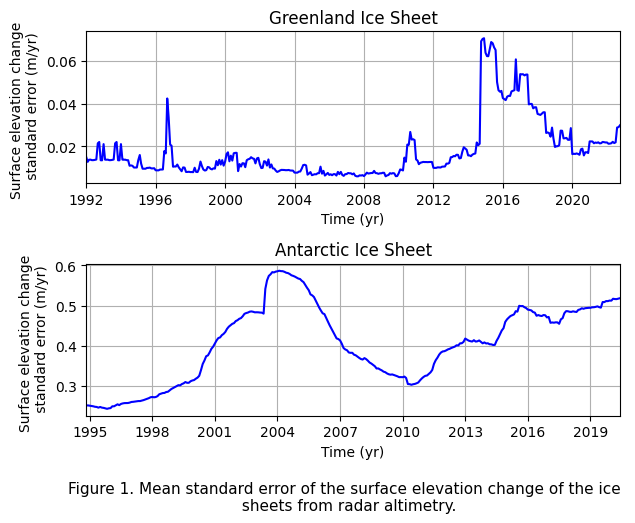

In [13]:
fig=plt.figure()
txt="Figure 1. Mean standard error of the surface elevation change of the ice \n sheets from radar altimetry."
plt.figtext(0.55, -0.07,txt, wrap=True, horizontalalignment='center', fontsize=11)
# GrIS
plt.subplot(2,1,1)
plt.plot(decimal_year_gris, mean_sec_err_gris_time,color='blue')
plt.ylabel("Surface elevation change \n standard error (m/yr)")
plt.title("Greenland Ice Sheet")
plt.xlabel("Time (yr)")
plt.xticks([1992,1996,2000,2004,2008,2012,2016,2020])
plt.xlim(decimal_year_gris[0], decimal_year_gris[-1])
plt.grid()
# AIS
plt.subplot(2,1,2)
plt.plot(decimal_year_ais, mean_sec_err_ais_time,color='blue')
plt.ylabel("Surface elevation change \n standard error (m/yr)")
plt.xlabel("Time (yr)")
plt.title("Antarctic Ice Sheet")
plt.xticks([1995,1998,2001,2004,2007,2010,2013,2016,2019,2022])
plt.xlim(decimal_year_ais[0], decimal_year_ais[-1])
plt.grid()
fig.tight_layout()
plt.show()

It must be noted that the standard error for both the GrIS and AIS seems to slightly increase with time. It must be mentioned that the mean standard error of the AIS is, however, also not at its minimum GCOS requierement, which is set to a threshold of 0.1 m yr^-1 (World Meteorological Organization, 2022).

At last, the spatial distribution of the multiyear mean surface elevation change standard error data are ready to be plotted:

<Figure size 640x480 with 0 Axes>

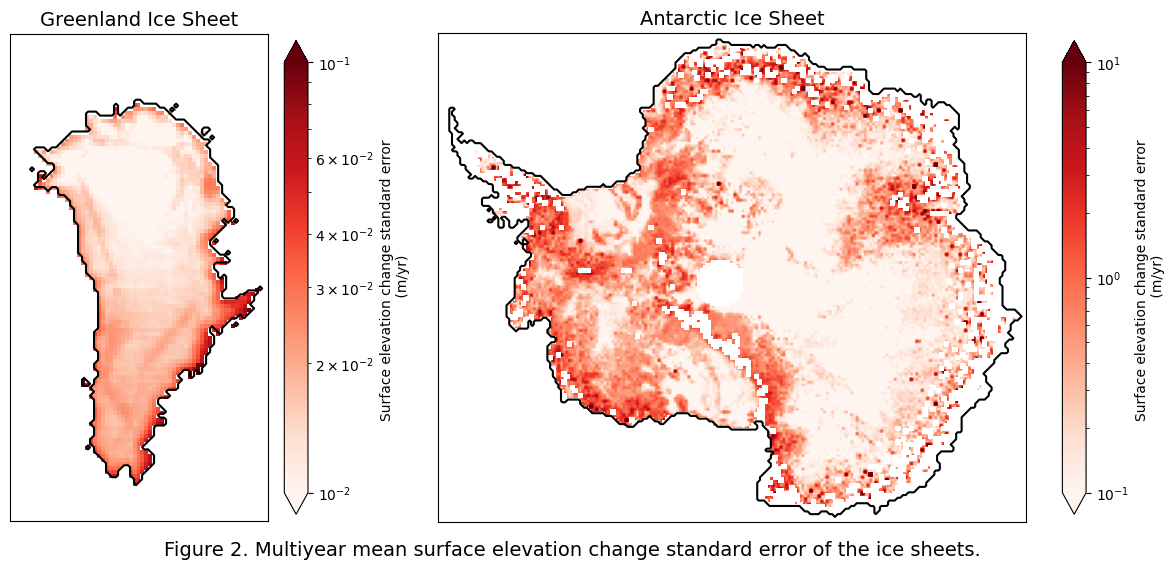

In [79]:
fig=plt.figure()
plt.subplots(1, 2,  figsize=(15, 15), gridspec_kw={'width_ratios': [1, 2.275]});
warnings.filterwarnings('ignore')
txt="Figure 2. Multiyear mean surface elevation change standard error of the ice sheets."
plt.figtext(0.5, 0.31,txt, wrap=True, horizontalalignment='center', fontsize=14)
# GrIS
plt.subplot(1, 2, 1)
imgplot = plt.imshow(mean_sec_err_gris, cmap='Reds',norm = colors.LogNorm())
c = plt.colorbar(extend='both',shrink=0.41)
plt.clim(1e-2,1e-1)
ax = plt.gca()
ax.set_xticks([]);
ax.set_yticks([]);
plt.gca().invert_yaxis()
ax.set_title('Greenland Ice Sheet', fontsize=14)
c.set_label('Surface elevation change standard error \n (m/yr)')
yc = np.linspace(0, landmask_gris.shape[0], landmask_gris.shape[0])
xc = np.linspace(0, landmask_gris.shape[1], landmask_gris.shape[1])
X, Y = np.meshgrid(xc, yc)
plt.contour(X, Y, landmask_gris,[0.5],colors='black');
# AIS
plt.subplot(1, 2, 2)
imgplot = plt.imshow(mean_sec_err_ais, cmap='Reds',norm = colors.LogNorm())
c = plt.colorbar(extend='both',shrink=0.41)
plt.clim(1e-1,1e1)
ax = plt.gca()
ax.set_xticks([]);
ax.set_yticks([]);
plt.gca().invert_yaxis()
ax.set_title('Antarctic Ice Sheet', fontsize=14)
c.set_label('Surface elevation change standard error \n (m/yr)')
yc = np.linspace(0, landmask_ais.shape[0], landmask_ais.shape[0])
xc = np.linspace(0, landmask_ais.shape[1], landmask_ais.shape[1])
X, Y = np.meshgrid(xc, yc)
plt.contour(X, Y, landmask_ais,[0.5],colors='black');
fig.tight_layout()

Let's calculate the average standard error of the surface elevation changes for both ice sheets:

In [42]:
print(f'The average ice sheet-wide surface elevation change standerd error of the GrIS during the observed period is {np.mean(mean_sec_err_gris_time):.4f}','m/yr.')
print(f'The average ice sheet-wide surface elevation change standard error of the AIS during the observed period is {np.mean(mean_sec_err_ais_time):.4f}','m/yr.')

The average ice sheet-wide surface elevation change standerd error of the GrIS during the observed period is 0.0177 m/yr.
The average ice sheet-wide surface elevation change standard error of the AIS during the observed period is 0.4057 m/yr.


The error values therefore meet the minimum requirement proposed by the GCOS (Global Climate Observing System).

#### Let us research the explanatory variables for the spatial pattern of the uncertainty values.

As can be seen from the image above, the standard error values exhibit high spatial variability and are clearly larger in magnitude for the AIS than for the GrIS. We can check whether a relationship exists between the standard error and the slope of the terrain, as well as for the magnitude of the SEC itself. The link between the surface elevation change magnitude and its uncertainty is further illustrated below:

LinregressResult(slope=nan, intercept=nan, rvalue=nan, pvalue=nan, stderr=nan, intercept_stderr=nan)


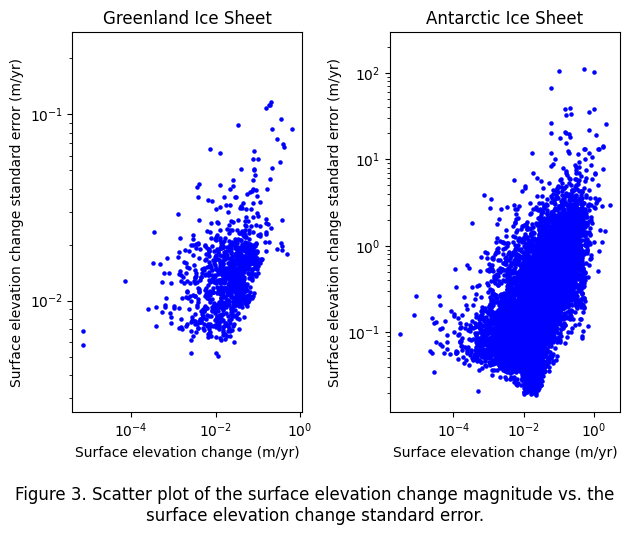

In [89]:
fig=plt.figure()
txt="Figure 3. Scatter plot of the surface elevation change magnitude vs. the surface elevation change standard error.";
plt.figtext(0.5, -0.09,txt, wrap=True, horizontalalignment='center', fontsize=12);
# GrIS
plt.subplot(1, 2, 1)
plt.scatter(np.ravel(mean_sec_gris), np.ravel(mean_sec_err_gris),s=5,c='blue')
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlabel("Surface elevation change (m/yr)")
plt.ylabel("Surface elevation change standard error (m/yr)")
plt.title("Greenland Ice Sheet")
# AIS
plt.subplot(1, 2, 2)
plt.scatter(np.ravel(mean_sec_ais), np.ravel(mean_sec_err_ais),s=5,c='blue')
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlabel("Surface elevation change (m/yr)")
plt.ylabel("Surface elevation change standard error (m/yr)")
plt.title("Antarctic Ice Sheet")
fig.tight_layout()
plt.show()

The standard error is shown to clearly increase with an increasing magnitude of the SEC itself. This may be, amongst others, related to rapid and extensive changes of the surface, hence complicating proper comparison of the surface elevation between different acquisition times. 

Additionally, let us check the relationship with the surface slope:

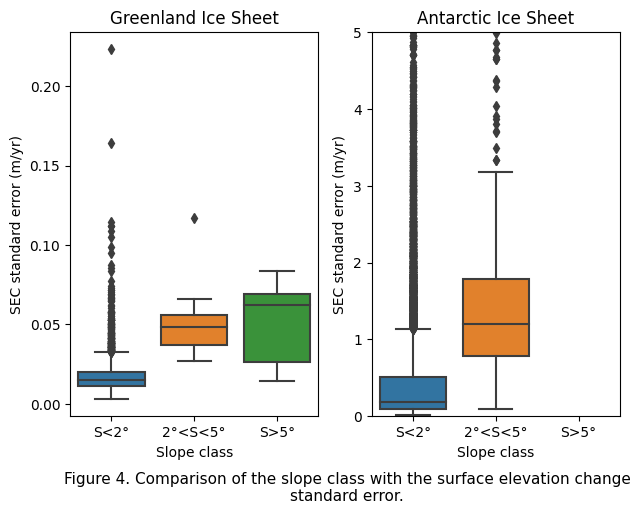

In [78]:
# Create a boxplot
fig=plt.figure()
txt="Figure 4. Comparison of the slope class with the surface elevation change standard error."
plt.figtext(0.55, -0.05,txt, wrap=True, horizontalalignment='center', fontsize=11)
# GrIS
plt.subplot(1,2,1)
df=pd.DataFrame({'slopemask_gris': np.ravel(slopemask_gris), 'mean_sec_err_gris':np.ravel(mean_sec_err_gris)});
ax=sns.boxplot(data=df, x='slopemask_gris', y='mean_sec_err_gris');
ax.set_ylabel('SEC standard error (m/yr)')
ax.set_xlabel('Slope class');
plt.title("Greenland Ice Sheet")
ax.set_xticklabels(["S<2°","2°<S<5°","S>5°"]);
# AIS
plt.subplot(1,2,2)
df=pd.DataFrame({'slopemask_ais': np.ravel(slopemask_ais), 'mean_sec_err_ais':np.ravel(mean_sec_err_ais)});
ax=sns.boxplot(data=df, x='slopemask_ais', y='mean_sec_err_ais');
plt.title("Antarctic Ice Sheet")
ax.set_xlabel('Slope class');
ax.set_ylabel('SEC standard error (m/yr)')
ax.set_xticklabels(["S<2°","2°<S<5°","S>5°"]);
plt.ylim([0, 5]);
fig.tight_layout()
plt.show()

From the plots above, it can be seen that larger values of the standard error are generally found at the margins, where steep slopes and fast changing surface conditions are present. This can be linked to, for example, a more pronounced seasonal cycle of accumulation and snow/ice melting, which allows the recurring presence of melt water. This may affect the data when, for example, temporal variations in snowpack liquid water content alter the penetration depth of the radar pulse, which may introduce artificial elevation changes. Also pixels with higher surface slopes, generally found along the margins, exhibit relatively larger standard errors.

# Conclusion

#### Key strengths and key weaknesses

<u>Key strengths</u>:

• The data have no temporal gaps, have a long temporal extent since 1992 and are found to be suitable to derive mean values, variability and trends (climate change signals).<br>
• Data include quantitative error and uncertainty characterization measures in the form of
gridded errors, validity flag maps and slope class masks.<br>
• The temporal resolution, the average accuracy (for the GrIS), and the number of observations all satisfy the minimum or the optimum GCOS requirements (World Meteorological Organization, 2022).<br>
• There is an abundant amount of guidance or help documents freely and publicly available. Contact information is also provided.<br>
• The guidance documents are regularly updated and include feedback. References to scientific peer-reviewed literature are also provided.<br>
• The data files are accompanied by extensive metadata that meet international standards and provide the user with additional information.<br>
• Data have been used in peer-reviewed research and decision support systems (e.g. Sørensen et al., 2018; Schröder et al., 2019; Fox-Kemper et al., 2021).<br>

<u>Key weaknesses</u>:

• The spatial resolution is too coarse (25 km) with respect to the GCOS requirements (World Meteorological Organization, 2022).<br>
• The GrIS file lacks data for the peripheral glaciers and ice caps, and missing spatial data on the
main ice sheet have been filled up. The AIS file contains more spatially missing data, due
to the large polar gap and unfilled spatial data gaps (especially around the margins).<br>
• The AIS SEC products seem to be of slightly lower quality than their GrIS counterpart (i.e. a
larger polar gap, more left-over unfilled spatial data gaps, more noisy data and a higher
overall standard error that does not meet the GCOS requirement of 0.1 m yr^-1).<br>
• Data around the margins and in complex terrain (high slope and ablation areas) of the ice sheets are especially sensitive to errors, with slightly lower quality data in these areas.<br>
• Data represent ice sheet surface elevation (i.e. volume) changes. If mass change data are required, SEC data need to be at first corrected for non-mass change processes (e.g. firn densification and vertical bed motion) and converted to mass change using appropriate density values.<br>

#### Take-home messages

Surface elevation change detection by radar altimetry is a useful tool to grasp the impact of climate change on the ice sheets. The dataset, however, also has its limitations of which the user should take note before using the product. When using the SEC data, users should therefore be aware of the typical problem areas for radar altimetry-derived SEC products. Consulting the accompanying uncertainty measures, for example the standard error, is therefore recommended to assess the error and accuracy characterization of the product. It follows that especially the ice sheet margins contain slightly lower quality data due to the presence of complex terrain, with an increased risk of high-slope errors, potentially blocked signals and the presence of rapidly changing surface conditions such rapidly flowing glaciers or the seasonal cycle of melt/runoff and accumulation. Here, snow melting allows, for example, for variable snowpack penetration depths of the radar pulse (e.g. due to a changing liquid water content or refrozen ice lenses), hence possibly introducing artificial elevation changes. Also large and rapid changes of the surface, complicating proper comparison between different acquisition times, can be at stake (e.g. a change of surface slope). In these areas, relatively higher standard errors can be found. When using the product, users should, for proper interpretation, also keep in mind that also other processes besides surface melt and accumulation may contribute to surface height change (e.g. dynamic processes, bed processes, firn compaction/densification processes, isostatic adjustment, tidal regimes, etc.), and hence that surface elevation changes do not necessarily equal mass changes.

# References

Fox-Kemper, B., H.T. Hewitt, C. Xiao, G. Aðalgeirsdóttir, S.S. Drijfhout, T.L. Edwards, N.R. Golledge, M. Hemer, R.E. Kopp, G. Krinner, A. Mix, D. Notz, S. Nowicki, I.S. Nurhati, L. Ruiz, J.-B. Sallée, A.B.A. Slangen, and Y. Yu (2021). Ocean, Cryosphere and Sea Level Change. In Climate Change 2021: The Physical Science Basis. Contribution of Working Group I to the Sixth Assessment Report of the Intergovernmental Panel on Climate Change [Masson-Delmotte, V., P. Zhai, A. Pirani, S.L. Connors, C. Péan, S. Berger, N. Caud, Y. Chen, L. Goldfarb, M.I. Gomis, M. Huang, K. Leitzell, E. Lonnoy, J.B.R. Matthews, T.K. Maycock, T. Waterfield, O. Yelekçi, R. Yu, and B. Zhou (eds.)]. Cambridge University Press, Cambridge, United Kingdom and New York, NY, USA, pp. 1211–1362, https://doi.org/110.1017/9781009157896.011.

Schröder, L., Horwath, M., Dietrich, R., Helm, V., van den Broeke, M.R., and Ligtenberg, S.R.M. (2019). Four decades of Antarctic surface elevation change from multi-mission satellite altimetry. The Cryosphere, 13, p. 427-449. https://doi.org/10.5194/tc-13-427-2019.

Shepherd, A., Ivins, E.R. Barletta, V.R., Bentley, M.J,, Bettadpur, S., Briggs, K.H., Bromwich, D.H., Forsberg, R., Galin, N., Horwath, M., Jacobs, S., Joughin, I., King, M.A., Lenaerts, J.T., Li, J., Ligtenberg, S.R., Luckman, A., Luthcke, S.B., McMillan, M., Meister, R., Milne, G., Mouginot, J., Muir, A., Nicolas, J.P., Paden, J., Payne, A.J., Pritchard, H., Rignot, E., Rott, H., Sørensen, L.S., Scambos, T.A., Scheuchl, B., Schrama, E.J., Smith, B., Sundal, A.V., van Angelen, J.H., van de Berg W.J., van den Broeke, M.R., Vaughan, D.G., Velicogna, I., Wahr, J., Whitehouse, P.L., Wingham, D.J., Yi, D., Young, D., Zwally, H.J. (2012). A Reconciled Estimate of Ice-Sheet Mass Balance. Science, 338 (6111). https://doi.org/10.1126/science.1228102.

Shepherd, A., Gilbert, L., Muir, A.S., Konrad, H., McMillan, M., Slater, T., Briggs, H.K., Sundal, A. V., Hogg A.E., and Engdahl, M.E. (2019). Trends in Antarctic Ice Sheet elevation and mass. Geophysical Research Letters, 46, p. 8174-8183. https://doi.org/10.1029/2019GL082182.

Sørensen, L.S., Simonsen, L., Sebastian, B., Forsberg, R., Khvorostovsky, K., Meister, R., and Engdahl, M. E. (2018). 25 years of elevation changes of the Greenland Ice Sheet from ERS, Envisat, and CryoSat-2 radar altimetry, Earth and Planetary Science Letters. 495. https://doi.org/10.1016/j.epsl.2018.05.015.

World Meteorological Organization (2022). The 2022 GCOS ECVs Requirements (GCOS-245). World Meteorological Organization: Geneva, Switzerland. 